In [38]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import networkit as nk
from collections import defaultdict
from itertools import combinations
from tqdm import tqdm
import csv
from networkx.algorithms import bipartite

sns.set_context("paper", font_scale=1.6)
sns.set_style("white")

# Podstawowe informacje


In [39]:
with open("../data/bipartite_graph.gpickle", "rb") as f:
    G = pickle.load(f)

In [40]:
users = [n for n, d in G.nodes(data=True) if d["bipartite"] == 0]
books = [n for n, d in G.nodes(data=True) if d["bipartite"] == 1]

In [41]:
print(f"Nodes: {G.number_of_nodes():,}  |  Edges: {G.number_of_edges():,}")
print(f"Users: {len(users):,} | Books: {len(books):,}")
print(f"Density: {nx.bipartite.density(G, users)}")
print(f"Density: {nx.bipartite.density(G, books)}")

Nodes: 200,217  |  Edges: 8,272,041
Users: 93,622 | Books: 106,595
Density: 0.0008288919652488085
Density: 0.0008288919652488085


In [42]:
# density of bipartite graph
density_bipartite = len(G.edges) / (len(users) * len(books))
print(f"Density of bipartite graph: {density_bipartite:.6g}")

Density of bipartite graph: 0.000828892


# Projekcja users


In [ ]:
edge_weights = defaultdict(int)

for book in tqdm(books, desc="Przetwarzanie książek"):
    connected_users = [u for u in G.neighbors(book) if u in users]

    for u1, u2 in combinations(sorted(connected_users), 2):
        edge_weights[(u1, u2)] += 1

with open("user_projection.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["user1", "user2", "weight"])

    for (u1, u2), weight in edge_weights.items():
        writer.writerow([u1, u2, weight])

Przetwarzanie książek: 100%|██████████| 136/136 [01:17<00:00,  1.75it/s]


In [3]:
df_users = pd.read_csv("user_projection.csv")
df_users.head(5)

,user1,user2,weight
0,149190,237706,4
1,149190,273732,5
2,149190,380455,4
3,237706,273732,1
4,237706,380455,1


In [4]:
df_users.shape

(30437371, 3)

## Analiza projekcji users


In [4]:
G_users = nx.from_pandas_edgelist(
    df_users, "user1", "user2", edge_attr="weight", create_using=nx.Graph()
)
print(f"Nodes: {G_users.number_of_nodes():,}  |  Edges: {G_users.number_of_edges():,}")

Nodes: 13,936  |  Edges: 30,437,371


In [87]:
# gestosc
print(f"Gestosc: {nx.density(G_users):.6g}")

# sredni niewazony stopien wezla
print(
    f"Sredni niewazony stopien wezla: {np.mean(list(dict(G_users.degree()).values())):.6g}"
)

# wagi - ile srednio wspolnych ksiazek laczy pare uzytkownikow
print(
    f"Srednia waga krawedzi: {np.mean([df_users['weight'] for _, _, df_users in G_users.edges(data=True)])}"
)

Gestosc: 0.313467
Sredni niewazony stopien wezla: 4368.16
Srednia waga krawedzi: 1.0160292096186625


In [ ]:
# centralnosc i podobni uzytkownicy
strength = dict(G_users.degree(weight="weight"))
top10_strongest = sorted(strength.items(), key=lambda x: -x[1])[:10]
top10_strongest
# wynik to user i suma ksiazek ktore dzieli z innymi uzytkownikami

[(149190, 21505),
 (314593, 16370),
 (306946, 15644),
 (165642, 14896),
 (250334, 14371),
 (275124, 13995),
 (133160, 13870),
 (104712, 13628),
 (197031, 13026),
 (208698, 12968)]

In [6]:
G_users_nk = nk.nxadapter.nx2nk(G_users)

plm = nk.community.PLM(G_users_nk)
plm.run()
partion = plm.getPartition()
print(f"Number of communities: {partion.numberOfSubsets()}")

Number of communities: 4


In [7]:
d = nk.distance.EffectiveDiameterApproximation(G_users_nk)
d.run()
diam = d.getEffectiveDiameter()

print("≈Diameter:", diam)

≈Diameter: 1.9999282433983927


# Projekcja książek


In [70]:
edge_weights = defaultdict(int)

for user in tqdm(users, desc="Przetwarzanie książek"):
    connected_books = [b for b in G.neighbors(user) if b in books]

    for b1, b2 in combinations(sorted(connected_books), 2):
        edge_weights[(b1, b2)] += 1

with open("book_projection.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["book1", "book2", "weight"])

    for (b1, b2), weight in edge_weights.items():
        writer.writerow([b1, b2, weight])

Przetwarzanie książek: 100%|██████████| 113183/113183 [01:33<00:00, 1211.18it/s] 


In [71]:
df_books = pd.read_csv("book_projection.csv")
df_books.head(5)

,book1,book2,weight
0,1387,1526,752
1,36403,65670,5
2,18517,49057,40
3,18517,110940,3
4,18517,111312,6


In [72]:
df_books.shape

(9180, 3)

# Jakieś szybsze liczenie miar - cały graf


In [43]:
G_nk = nk.nxadapter.nx2nk(G)

In [44]:
plm = nk.community.PLM(G_nk)
plm.run()
partion = plm.getPartition()
print(f"Number of communities: {partion.numberOfSubsets()}")

Number of communities: 13


In [45]:
d = nk.distance.EffectiveDiameterApproximation(G_nk)
d.run()
diam = d.getEffectiveDiameter()
# apl  = nk.distance.APSP(G_nk, storePaths=False).run().getAveragePathLength()  # opcjonalnie

print("≈Diameter:", diam)

≈Diameter: 4.037699096480319


In [ ]:
# bc = nk.centrality.ApproxBetweenness(G_nk)
# bc.run()
# betweenness = bc.scores()
# nie wlaczac!!

In [ ]:
# # save betweenness scores to a CSV file
# with open("betweenness.csv", "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerow(["node", "betweenness"])

#     for node, score in zip(G.nodes(), betweenness):
#         writer.writerow([node, score])

In [ ]:
# betweenness = pd.read_csv("betweenness.csv")

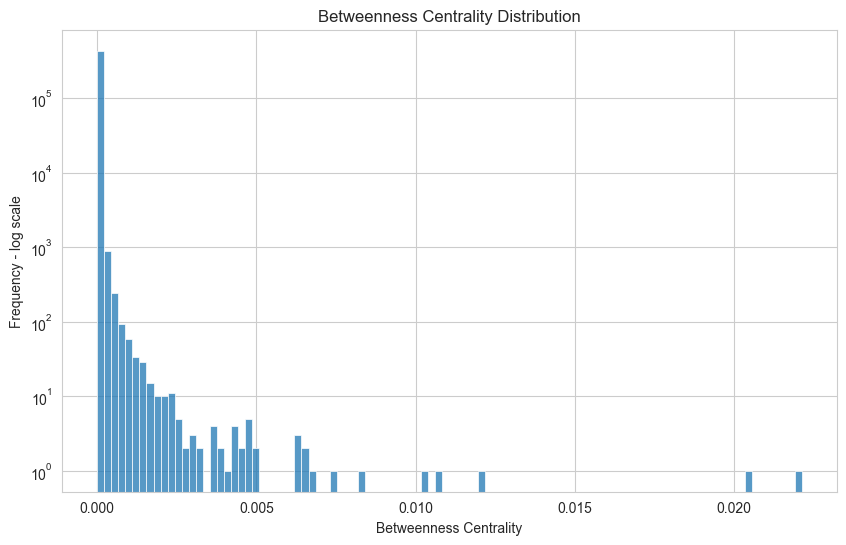

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 6))
# sns.histplot(betweenness, bins=100, ax=ax)
# ax.set_title("Betweenness Centrality Distribution")
# ax.set_xlabel("Betweenness Centrality")
# ax.set_ylabel("Frequency - log scale")
# ax.set_yscale("log")
# plt.show()

In [ ]:
# np.mean(betweenness)

5.36868080363216e-06

In [46]:
cc = nk.centrality.ApproxCloseness(G_nk, 100)
cc.run()
closeness = cc.scores()

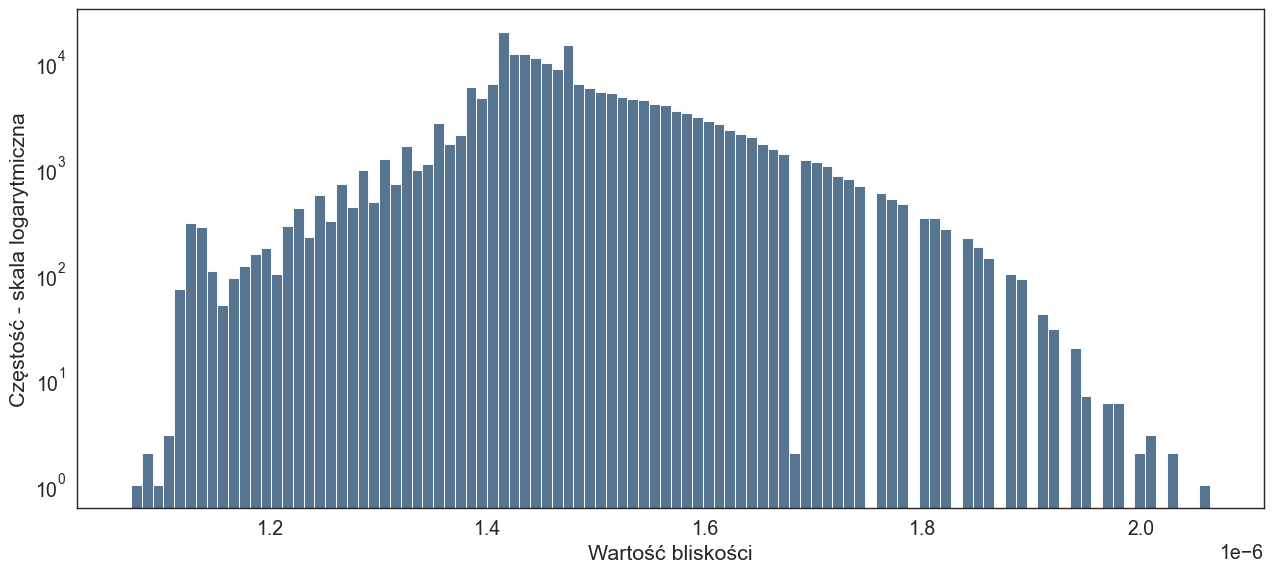

In [47]:
fig, ax = plt.subplots(figsize=(13, 6))
sns.histplot(closeness, bins=100, ax=ax, color="#577490", alpha=1)
ax.set_xlabel("Wartość bliskości")
ax.set_ylabel("Częstość - skala logarytmiczna")
ax.set_yscale("log")
plt.tight_layout()
plt.savefig("../output/pictures/closeness_distribution.png")

In [48]:
cc.ranking()[:10]

[(95386, 2.0638867048381136e-06),
 (93716, 2.030327571426112e-06),
 (95474, 2.030327571426112e-06),
 (6833, 2.0139539619791268e-06),
 (95267, 2.0139539619791268e-06),
 (95277, 2.0139539619791268e-06),
 (95276, 1.9978423302832938e-06),
 (95891, 1.9978423302832938e-06),
 (93793, 1.981986438773109e-06),
 (94720, 1.981986438773109e-06)]

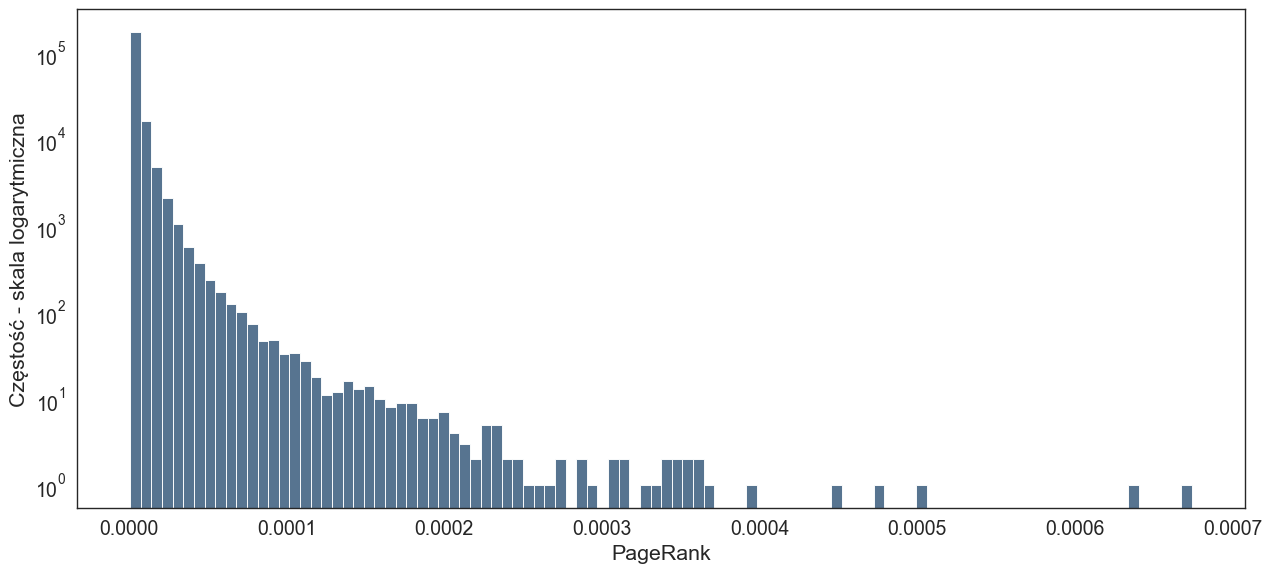

In [49]:
pr = nk.centrality.PageRank(G_nk, damp=0.85, tol=1e-5)
pr.run()
pagerank = pr.scores()

fig, ax = plt.subplots(figsize=(13, 6))

sns.histplot(pagerank, bins=100, ax=ax, color="#577490", alpha=1)
ax.set_xlabel("PageRank")
ax.set_ylabel("Częstość - skala logarytmiczna")
ax.set_yscale("log")
plt.tight_layout()
plt.savefig("../output/pictures/pagerank_distribution.png")

In [50]:
user_deg = [G.degree(u) for u in users]
book_deg = [G.degree(b) for b in books]

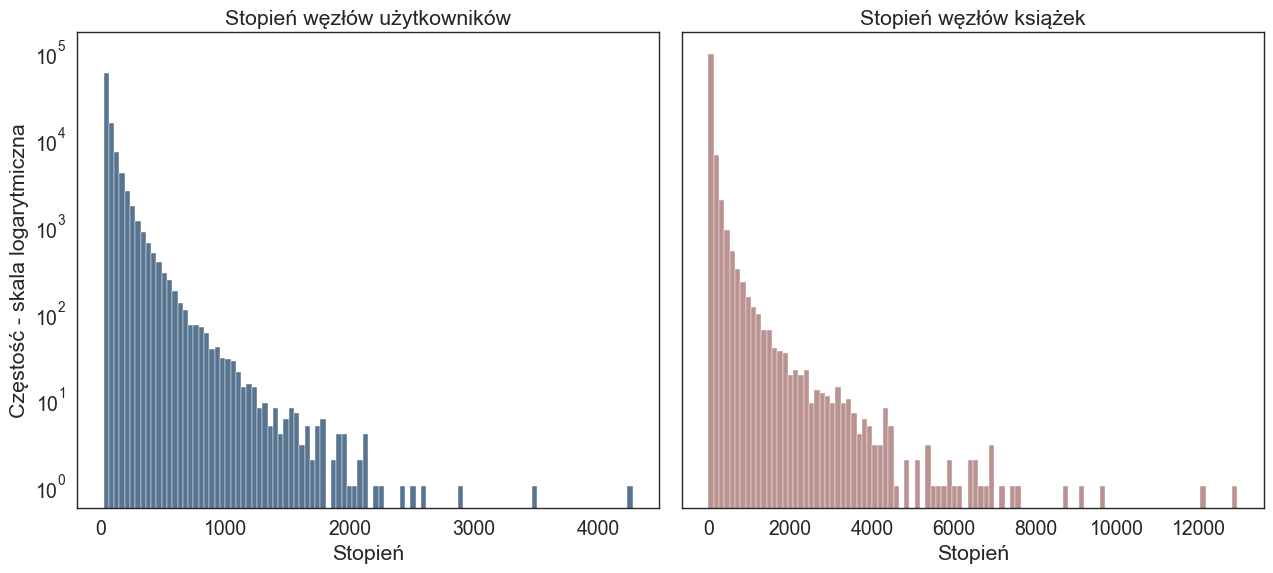

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6), sharey=True)
sns.histplot(user_deg, bins=100, ax=ax[0], color="#577490", alpha=1)
sns.histplot(book_deg, bins=100, ax=ax[1], color="#BA928F", alpha=1)
ax[0].set_title("Stopień węzłów użytkowników")
ax[1].set_title("Stopień węzłów książek")
ax[0].set_xlabel("Stopień")
ax[1].set_xlabel("Stopień")
ax[0].set_ylabel("Częstość - skala logarytmiczna")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
plt.tight_layout()
plt.savefig("../output/pictures/degree_distribution.png")

In [16]:
cc_sizes = [len(c) for c in nx.connected_components(G)]
print(f"Connected components: {len(cc_sizes)}, largest = {max(cc_sizes)}")

Connected components: 1, largest = 200217


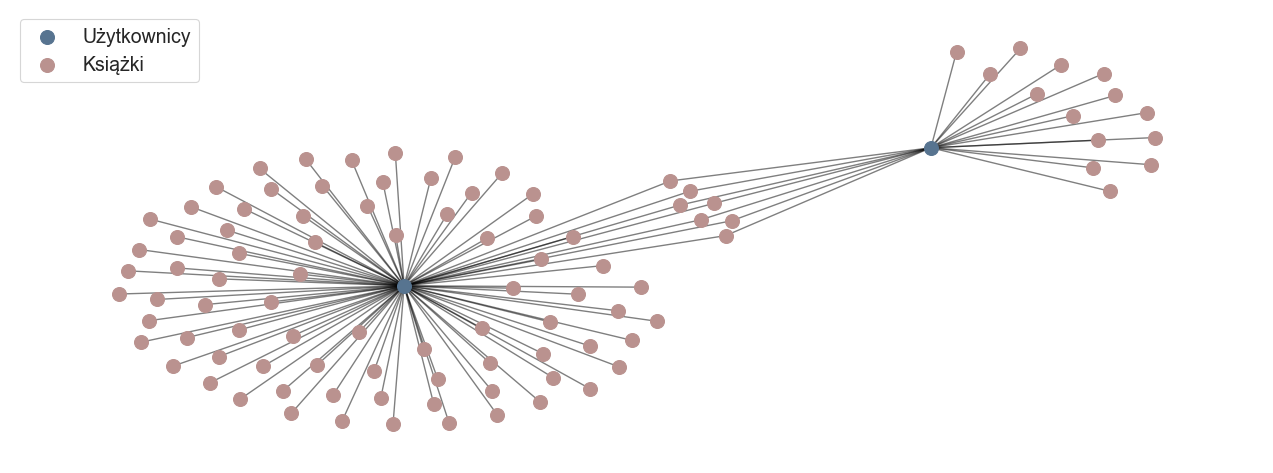

In [32]:
import nxviz as nv
from nxviz import annotate
import random

# sample_users = random.sample(users, 2)
# while not any(set(G.neighbors(sample_users[0])) & set(G.neighbors(sample_users[1]))):
#     sample_users = random.sample(users, 2)

sample_users = ["u_id_102342", "u_id_311548"]

# Find books connected to both users
common_books = set(G.neighbors(sample_users[0])) & set(G.neighbors(sample_users[1]))

books = set()
for user in sample_users:
    books.update(G.neighbors(user))

# Find books connected to only one of the users
not_connected_books = books - common_books

# Remove 50% of books not connected to both users
books_to_remove = random.sample(
    sorted(not_connected_books), len(not_connected_books) // 4 * 3
)
books.difference_update(books_to_remove)

sub_nodes = sample_users + list(books)
subG = G.subgraph(sub_nodes)

# fig, ax = plt.subplots(figsize=(13, 7))
# nv.circos(subG, node_color_by="bipartite")
# annotate.circos_group(subG, group_by="bipartite")
# plt.savefig("circos.png")

# plot the graph with node labels

fig, ax = plt.subplots(figsize=(13, 5))
pos = nx.spring_layout(subG)
# nx.draw(
#     subG, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=10
# )
nx.draw_networkx_nodes(
    subG,
    pos,
    nodelist=sample_users,
    node_color="#577490",
    node_size=100,
    label="Użytkownicy",
)
nx.draw_networkx_nodes(
    subG,
    pos,
    nodelist=books,
    node_color="#BA928F",
    node_size=100,
    label="Książki",
)
nx.draw_networkx_edges(subG, pos, alpha=0.5)
plt.axis("off")
plt.legend()
plt.tight_layout()
plt.savefig("../output/pictures/spring_layout.png")

In [86]:
fig.savefig("spring.png")

In [12]:
sample_users

['u_id_102342', 'u_id_311548']